### Exploration of subtasks / methodology:

 - ### Caption sentiment class extraction
 - ### Caption sentiment classifier
 - ### Image feature extraction Pipeline: 
     - VGG-16
     - Inception
     - AlexNet
         - According to [google's dataset paper](https://www.aclweb.org/anthology/P18-1238.pdf) Inception_Resnet_v2 is best for feature extraction
 - ### Image object detection/ data
 - ### Object + Sentiment sentence generation
 - ### End to End model from tutorial
 - ### Caption evaluation pipeline:
     - BLEU score
     - Perplexity?
 

## Initial loading and displaying

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
sample_data_folder = r'data/initial_sample/'
cleaned_meta_data_file = os.path.join(sample_data_folder,'cleaned_meta_data.csv')
images_folder = os.path.join(sample_data_folder,'images')

In [4]:
image_captions = pd.read_csv(cleaned_meta_data_file, index_col='index')
image_captions.rename(columns = {'0':'caption', '1':'link', '2':'objects', '3': 'mid', '4': 'object_confidence'}, inplace=True)
image_captions.head()


,caption,link,objects,mid,object_confidence,pos
index,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4


In [5]:
len(image_captions)

9303

In [6]:
#Add notebook relative file_path to image 
image_captions['image_path'] = image_captions['pos'].apply(lambda p: os.path.join(images_folder, str(p) + ".png"))
image_captions


,caption,link,objects,mid,object_confidence,pos,image_path
index,,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0,data/initial_sample/images\0.png
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1,data/initial_sample/images\1.png
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2,data/initial_sample/images\2.png
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3,data/initial_sample/images\3.png
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4,data/initial_sample/images\4.png
...,...,...,...,...,...,...,...
9625,adapted work to the universe .,https://i.pinimg.com/736x/b6/85/d9/b685d9287f3...,"text,sky,font,astronomical object,universe,atm...","/m/07s6nbt,/m/01bqvp,/m/03gq5hm,/m/01d9ll,/m/0...","0.9626815915107727,0.9585431814193726,0.945139...",9625,data/initial_sample/images\9625.png
9626,praying and folding hands over poetry book,https://media.istockphoto.com/photos/praying-a...,"white,black,hand,black-and-white,finger,monoch...","/m/083jv,/m/019sc,/m/0k65p,/m/01g6gs,/m/09cx8,...","0.9628557562828064,0.9571874141693115,0.937342...",9626,data/initial_sample/images\9626.png
9627,cute hand drawn seamless pattern with circles ...,https://thumb7.shutterstock.com/display_pic_wi...,"text,circle,font,pattern,line,design,number,il...","/m/07s6nbt,/m/01vkl,/m/03gq5hm,/m/0hwky,/m/03s...","0.9523645639419556,0.9162501692771912,0.908029...",9627,data/initial_sample/images\9627.png


In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
#load a few sample images with captions
def display_samples(meta_df, num_samples=5, seed = 0):
    #sample num_sample rows from the dataframe
    samples = meta_df.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidence'].split(',')
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(10,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        ax.set_title(caption)
        ax = fig.add_subplot(122)
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        







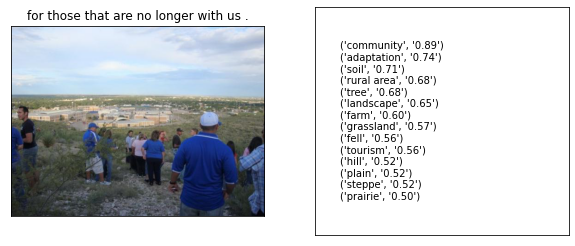

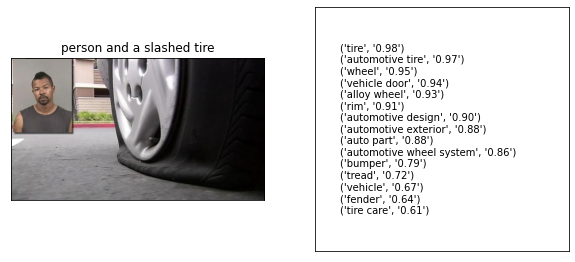

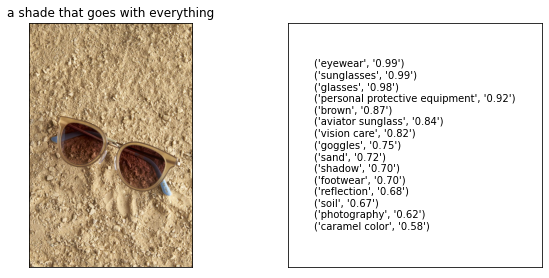

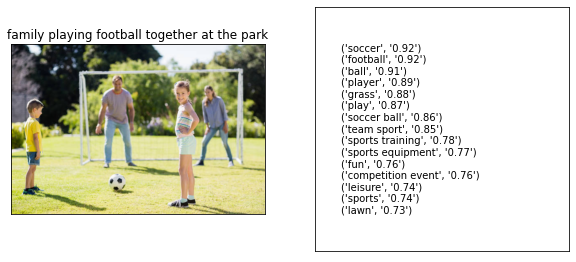

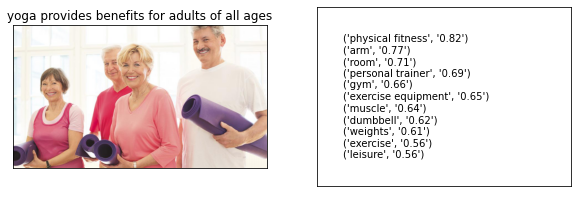

In [8]:
display_samples(image_captions)

## Profiling
- Size distribution of images
- Aspect Ration distribution of images: w/h
- Distribution of number of objects per image
- Distribution of number of objects at various confidence thresholds
- Distribution of caption size for each image

### Size distribution of images
This takes a while to run

In [9]:
image_captions['size'] = image_captions['image_path'].apply(lambda p: Image.open(p).size)
image_captions

,caption,link,objects,mid,object_confidence,pos,image_path,size
index,,,,,,,,
0,snowman on a red background,https://thumb10.shutterstock.com/display_pic_w...,"snowman,cartoon,christmas eve,greeting card,sa...","/m/0152hh,/m/0215n,/m/014r1s,/m/03r8dh,/m/027g...","0.9607862830162048,0.9256524443626404,0.869515...",0,data/initial_sample/images\0.png,"(450, 470)"
1,celebrity celebrates with his team mates after...,https://media.gettyimages.com/photos/david-bec...,"player,sports,tournament,sports equipment,team...","/m/02vzx9,/m/06ntj,/m/012sbd,/m/05y5lj,/m/03x0...","0.995377242565155,0.9889867305755615,0.9811984...",1,data/initial_sample/images\1.png,"(477, 612)"
2,"action shot of basketball player , passing the...",https://onwisconsin.uwalumni.com/content/uploa...,"sports,team sport,ball game,player,sport venue...","/m/06ntj,/m/03x045,/m/020m7t,/m/02vzx9,/m/0bmg...","0.9889867305755615,0.9755526781082153,0.974188...",2,data/initial_sample/images\2.png,"(1200, 801)"
3,a sunny winter day by lake .,https://s-media-cache-ak0.pinimg.com/originals...,"sky,snow,winter,natural landscape,nature,blue,...","/m/01bqvp,/m/06_dn,/m/086mh,/m/03d28y3,/m/05h0...","0.9884884357452393,0.9849196076393127,0.983304...",3,data/initial_sample/images\3.png,"(640, 640)"
4,"the extraordinary domed ceiling , with an arti...",https://i.pinimg.com/736x/7d/7a/bd/7d7abd23c2d...,"ceiling,chandelier,light fixture,lighting,arch...","/m/03gfsp,/m/02ws6z,/m/08jpwt,/m/019sc6,/m/03n...","0.9757712483406067,0.9078124165534973,0.849791...",4,data/initial_sample/images\4.png,"(467, 700)"
...,...,...,...,...,...,...,...,...
9625,adapted work to the universe .,https://i.pinimg.com/736x/b6/85/d9/b685d9287f3...,"text,sky,font,astronomical object,universe,atm...","/m/07s6nbt,/m/01bqvp,/m/03gq5hm,/m/01d9ll,/m/0...","0.9626815915107727,0.9585431814193726,0.945139...",9625,data/initial_sample/images\9625.png,"(500, 494)"
9626,praying and folding hands over poetry book,https://media.istockphoto.com/photos/praying-a...,"white,black,hand,black-and-white,finger,monoch...","/m/083jv,/m/019sc,/m/0k65p,/m/01g6gs,/m/09cx8,...","0.9628557562828064,0.9571874141693115,0.937342...",9626,data/initial_sample/images\9626.png,"(612, 408)"
9627,cute hand drawn seamless pattern with circles ...,https://thumb7.shutterstock.com/display_pic_wi...,"text,circle,font,pattern,line,design,number,il...","/m/07s6nbt,/m/01vkl,/m/03gq5hm,/m/0hwky,/m/03s...","0.9523645639419556,0.9162501692771912,0.908029...",9627,data/initial_sample/images\9627.png,"(450, 470)"


In [10]:
#number of different sizes:
image_captions['size'].describe()

count           9303
unique          3479
top       (450, 470)
freq             800
Name: size, dtype: object

In [11]:
#profiling widths and heights
image_captions['height'] = image_captions['size'].apply(lambda x: x[1])
image_captions['width'] = image_captions['size'].apply(lambda x: x[0])

In [12]:
image_captions['height'].describe()


count    9303.000000
mean      665.512953
std       332.147768
min       150.000000
25%       470.000000
50%       600.000000
75%       736.000000
max      5760.000000
Name: height, dtype: float64

In [13]:
image_captions['width'].describe()

count    9303.000000
mean      714.701709
std       366.482221
min       150.000000
25%       470.000000
50%       612.000000
75%       800.000000
max      5184.000000
Name: width, dtype: float64

<AxesSubplot:ylabel='Frequency'>

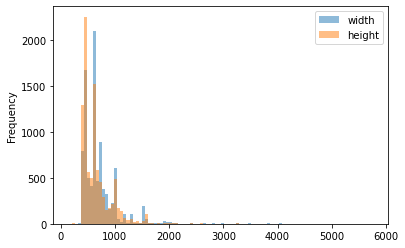

In [14]:
image_captions[['width','height']].plot.hist(bins=100, alpha=0.5)

In [15]:
#looks like most images have a height and width under 1000 

In [16]:
quant = 0.99
print(image_captions['height'].quantile(quant))
print(image_captions['width'].quantile(quant))

1893.9399999999987
2048.0


### Aspect ratio distribution of images

In [17]:
image_captions['aspect_ratio'] = image_captions.apply(lambda x: x.width/x.height , axis=1)

In [18]:
image_captions['aspect_ratio'].describe()

count    9303.000000
mean        1.127491
std         0.356388
min         0.477124
25%         0.779412
50%         1.000000
75%         1.493035
max         2.257143
Name: aspect_ratio, dtype: float64

In [19]:
quant = 0.99
print(image_captions['aspect_ratio'].quantile(quant))

1.7857142857142858


<AxesSubplot:ylabel='Frequency'>

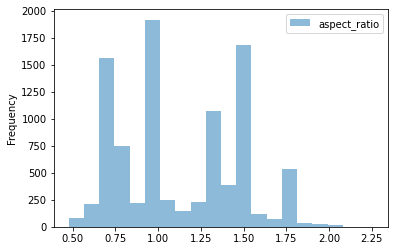

In [20]:
image_captions[['aspect_ratio']].plot.hist(bins=20, alpha=0.5)

### Number of objects per image

In [21]:
image_captions['num_obj'] = image_captions['objects'].apply(lambda o: 0 if pd.isna(o) else len(str(o).split(',')))

In [22]:
image_captions['num_obj'].describe()


count    9303.000000
mean       12.065678
std         3.626968
min         0.000000
25%         9.000000
50%        14.000000
75%        15.000000
max        15.000000
Name: num_obj, dtype: float64

In [23]:
image_captions['num_obj'].value_counts()


15    4489
12     534
11     519
10     499
9      493
13     452
14     447
8      442
7      437
6      346
5      271
4      181
3      124
2       47
1       18
0        4
Name: num_obj, dtype: int64

All but 4 images have atleast 1 object in them and a maximum of 15 objects in them and around 50% of the images have 15 objects detected

<AxesSubplot:ylabel='Frequency'>

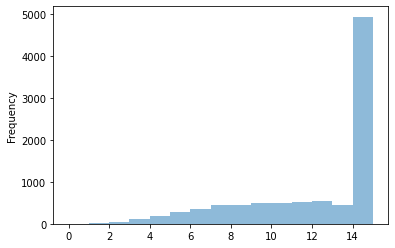

In [24]:
image_captions['num_obj'].plot.hist(bins=15, alpha=0.5)

### Distribution of num_objects at various confidence thresholds


In [25]:
def get_objects_with_conf_above(meta_df, threshold):
    """
    Returns a Series with a list of tuples (object,float) of object and confidence with confidence greater that threshold.
    """

    #object_conf tuple for objects with confidence above threshold
    obj_conf = image_captions.apply(lambda x: [] if (pd.isna(x.objects) or pd.isna(x.object_confidence))
                                   else [(obj,float(conf)) for (obj,conf) in zip(x.objects.split(','), x.object_confidence.split(',')) 
                                        if float(conf) >=threshold], axis=1)
    return obj_conf
    


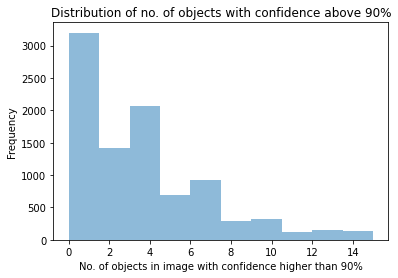

Number of images with atleast 1 caption with confidence higher than 90%: 7725


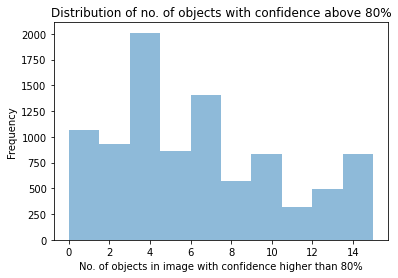

Number of images with atleast 1 caption with confidence higher than 80%: 8916


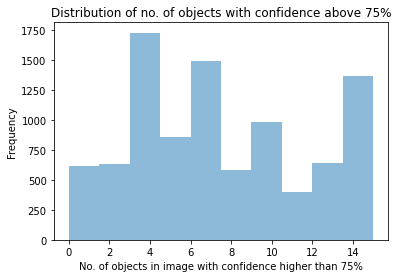

Number of images with atleast 1 caption with confidence higher than 75%: 9105


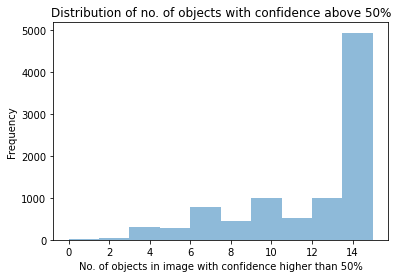

Number of images with atleast 1 caption with confidence higher than 50%: 9299


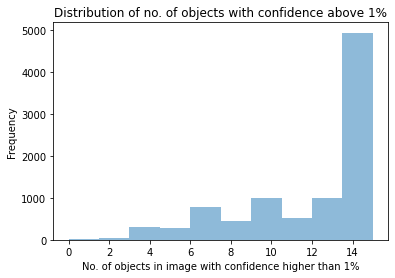

Number of images with atleast 1 caption with confidence higher than 1%: 9299


In [26]:
#get number of objects at various thresholds and plot them
thresholds = [90,80,75,50,1]
for t in thresholds:
    num_obj_conf = get_objects_with_conf_above(image_captions,(t*0.01)).apply(lambda l: len(l))
    num_obj_conf.plot.hist(alpha=0.5,title=f"Distribution of no. of objects with confidence above {t}%").set_xlabel(f"No. of objects in image with confidence higher than {t}%")
    plt.show()
    print(f"Number of images with atleast 1 caption with confidence higher than {t}%:",len(num_obj_conf[num_obj_conf > 0]))   


## Divide captions into sentiment classes. 

 - nltk's pretrained SentimentIntensityAnalyser: sentiment and polarity
 - huggingface pretrained classifier

### NLTK's pretrained classifer and polarity scores

In [27]:
import nltk


In [28]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [29]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
random_sample

,caption,link,objects,mid,object_confidence,pos,image_path,size,height,width,aspect_ratio,num_obj
index,,,,,,,,,,,,
3821,for those that are no longer with us .,https://media-cdn.tripadvisor.com/media/photo-...,"community,adaptation,soil,rural area,tree,land...","/m/01qls,/m/03r_vp,/m/09dv7,/m/01f4td,/m/07j7r...","0.8980977535247803,0.7408301830291748,0.718576...",3821,data/initial_sample/images\3821.png,"(550, 412)",412,550,1.334951,14
309,person and a slashed tire,http://cdn.abclocal.go.com/content/kgo/images/...,"tire,automotive tire,wheel,vehicle door,alloy ...","/m/0h9mv,/m/0h8pb3l,/m/083wq,/m/02q2kc3,/m/02q...","0.9858981370925903,0.9743779301643372,0.958666...",309,data/initial_sample/images\309.png,"(1280, 720)",720,1280,1.777778,15
4394,a shade that goes with everything,https://i.pinimg.com/736x/7c/56/d4/7c56d4fb8e7...,"eyewear,sunglasses,glasses,personal protective...","/m/0j272k5,/m/017ftj,/m/0jyfg,/m/0ffjr,/m/09q2...","0.99713534116745,0.9918914437294006,0.98605936...",4394,data/initial_sample/images\4394.png,"(736, 1103)",1103,736,0.667271,15
2004,family playing football together at the park,https://media.istockphoto.com/photos/family-pl...,"soccer,football,ball,player,grass,play,soccer ...","/m/02vx4,/m/01226z,/m/018xm,/m/02vzx9,/m/08t9c...","0.9207688570022583,0.9202115535736084,0.910375...",2004,data/initial_sample/images\2004.png,"(612, 408)",408,612,1.500000,15
2427,yoga provides benefits for adults of all ages,http://www.umcvc.org/sites/default/files/style...,"physical fitness,arm,room,personal trainer,gym...","/m/027x7n,/m/0dzf4,/m/06ht1,/m/0pyrb,/m/016yx7...","0.8204354047775269,0.7759444117546082,0.713922...",2427,data/initial_sample/images\2427.png,"(914, 514)",514,914,1.778210,11
3769,a model walks the runway at the fashion show d...,https://media.gettyimages.com/photos/model-wal...,"clothing,fashion,overcoat,outerwear,coat,fashi...","/m/09j2d,/m/032tl,/m/03tvvb,/m/047vlmn,/m/01xy...","0.9766733646392822,0.9262140989303589,0.906896...",3769,data/initial_sample/images\3769.png,"(407, 612)",612,407,0.665033,15
33,foggy landscape of a park with the title overt...,https://www.kcad.edu/uploads/cache/sized/uploa...,"natural landscape,atmospheric phenomenon,text,...","/m/03d28y3,/m/07pw27b,/m/07s6nbt,/m/01bqvp,/m/...","0.9398155808448792,0.8941346406936646,0.890130...",33,data/initial_sample/images\33.png,"(600, 452)",452,600,1.327434,15
1171,everything in these eyes by person on 500px,https://i.pinimg.com/736x/d1/8f/3b/d18f3bde9c0...,"hair,face,lip,beauty,photo shoot,model,shoulde...","/m/03q69,/m/0dzct,/m/06pj2k,/m/01f43,/m/02qbl1...","0.9768130779266357,0.9716733694076538,0.954374...",1171,data/initial_sample/images\1171.png,"(681, 1024)",1024,681,0.665039,15
6075,pancakes will be available sunday,https://www.gannett-cdn.com/-mm-/fd98079f61a28...,"dish,food,cuisine,pancake,breakfast,ingredient...","/m/02q08p0,/m/02wbm,/m/01ykh,/m/01dwwc,/m/0hz4...","0.9934034943580627,0.9903261065483093,0.986420...",6075,data/initial_sample/images\6075.png,"(544, 408)",408,544,1.333333,15


In [30]:
random_sample['nltk_sent_int'] = random_sample['caption'].apply(lambda x: sia.polarity_scores(x))
#classify using polarity scores: class with max polarity
random_sample['nltk_sent'] = random_sample['nltk_sent_int'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))
random_sample['nltk_sent'] 

index
3821    neu
309     neu
4394    neu
2004    neu
2427    neu
3769    neu
33      neu
1171    neu
6075    neu
9455    pos
7992    neu
8610    neu
4677    neu
6926    neu
2260    neu
4376    neu
40      neu
7296    neu
662     neu
7256    neu
31      neu
5627    neu
3337    pos
3472    neu
5840    neu
7318    neu
7342    neu
3859    neu
9205    neu
605     neu
5786    neu
6672    neu
7177    neu
8598    neu
2164    neu
9625    neu
8405    neu
5229    neu
4705    neu
7124    neu
6795    neu
5948    neu
5675    neu
7666    neu
1712    neu
1280    neu
2495    neu
9497    neu
3370    neu
9513    neu
Name: nltk_sent, dtype: object

In [31]:
#now do this pfor everything and plot histogram of classes
image_captions['nltk_sent_polarity'] = image_captions['caption'].apply(lambda x: sia.polarity_scores(x))

In [32]:
image_captions['nltk_sent'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['neu', 'pos','neg'], key=x.get))

In [33]:
image_captions['nltk_sent'].describe()

count     9303
unique       3
top        neu
freq      9088
Name: nltk_sent, dtype: object

In [34]:
image_captions['nltk_sent'].value_counts()

neu    9088
pos     188
neg      27
Name: nltk_sent, dtype: int64

<AxesSubplot:>

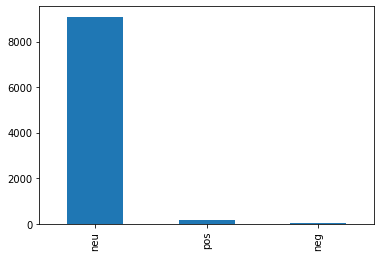

In [35]:
image_captions['nltk_sent'].value_counts().plot(kind='bar')

As we can see (and as expected), the overwhelming majority of captions are neutral

We can try limiting to the sentiment with max polarity among just positive and negative

In [36]:
image_captions['nltk_sent_pos_neg'] = image_captions['nltk_sent_polarity'].apply(lambda x: max(['pos','neg'], key=x.get))

In [37]:
image_captions['nltk_sent_pos_neg'].value_counts()

pos    8518
neg     785
Name: nltk_sent_pos_neg, dtype: int64

<AxesSubplot:>

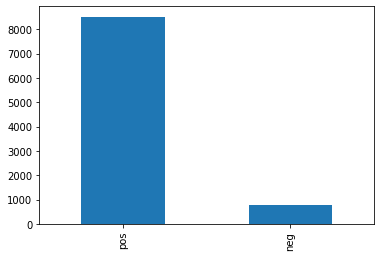

In [38]:
image_captions['nltk_sent_pos_neg'].value_counts().plot(kind='bar')

Still, classes are very unbalanced. 

## Huggingface's pretrained classifier

In [39]:

from transformers import pipeline


In [40]:
hf_sent = pipeline('sentiment-analysis')


In [41]:
#example on random captions

random_sample = image_captions.sample(n=50, random_state=0)
random_sample

,caption,link,objects,mid,object_confidence,pos,image_path,size,height,width,aspect_ratio,num_obj,nltk_sent_polarity,nltk_sent,nltk_sent_pos_neg
index,,,,,,,,,,,,,,,
3821,for those that are no longer with us .,https://media-cdn.tripadvisor.com/media/photo-...,"community,adaptation,soil,rural area,tree,land...","/m/01qls,/m/03r_vp,/m/09dv7,/m/01f4td,/m/07j7r...","0.8980977535247803,0.7408301830291748,0.718576...",3821,data/initial_sample/images\3821.png,"(550, 412)",412,550,1.334951,14,"{'neg': 0.239, 'neu': 0.761, 'pos': 0.0, 'comp...",neu,neg
309,person and a slashed tire,http://cdn.abclocal.go.com/content/kgo/images/...,"tire,automotive tire,wheel,vehicle door,alloy ...","/m/0h9mv,/m/0h8pb3l,/m/083wq,/m/02q2kc3,/m/02q...","0.9858981370925903,0.9743779301643372,0.958666...",309,data/initial_sample/images\309.png,"(1280, 720)",720,1280,1.777778,15,"{'neg': 0.388, 'neu': 0.612, 'pos': 0.0, 'comp...",neu,neg
4394,a shade that goes with everything,https://i.pinimg.com/736x/7c/56/d4/7c56d4fb8e7...,"eyewear,sunglasses,glasses,personal protective...","/m/0j272k5,/m/017ftj,/m/0jyfg,/m/0ffjr,/m/09q2...","0.99713534116745,0.9918914437294006,0.98605936...",4394,data/initial_sample/images\4394.png,"(736, 1103)",1103,736,0.667271,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos
2004,family playing football together at the park,https://media.istockphoto.com/photos/family-pl...,"soccer,football,ball,player,grass,play,soccer ...","/m/02vx4,/m/01226z,/m/018xm,/m/02vzx9,/m/08t9c...","0.9207688570022583,0.9202115535736084,0.910375...",2004,data/initial_sample/images\2004.png,"(612, 408)",408,612,1.500000,15,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",neu,pos
2427,yoga provides benefits for adults of all ages,http://www.umcvc.org/sites/default/files/style...,"physical fitness,arm,room,personal trainer,gym...","/m/027x7n,/m/0dzf4,/m/06ht1,/m/0pyrb,/m/016yx7...","0.8204354047775269,0.7759444117546082,0.713922...",2427,data/initial_sample/images\2427.png,"(914, 514)",514,914,1.778210,11,"{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'comp...",neu,pos
3769,a model walks the runway at the fashion show d...,https://media.gettyimages.com/photos/model-wal...,"clothing,fashion,overcoat,outerwear,coat,fashi...","/m/09j2d,/m/032tl,/m/03tvvb,/m/047vlmn,/m/01xy...","0.9766733646392822,0.9262140989303589,0.906896...",3769,data/initial_sample/images\3769.png,"(407, 612)",612,407,0.665033,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos
33,foggy landscape of a park with the title overt...,https://www.kcad.edu/uploads/cache/sized/uploa...,"natural landscape,atmospheric phenomenon,text,...","/m/03d28y3,/m/07pw27b,/m/07s6nbt,/m/01bqvp,/m/...","0.9398155808448792,0.8941346406936646,0.890130...",33,data/initial_sample/images\33.png,"(600, 452)",452,600,1.327434,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos
1171,everything in these eyes by person on 500px,https://i.pinimg.com/736x/d1/8f/3b/d18f3bde9c0...,"hair,face,lip,beauty,photo shoot,model,shoulde...","/m/03q69,/m/0dzct,/m/06pj2k,/m/01f43,/m/02qbl1...","0.9768130779266357,0.9716733694076538,0.954374...",1171,data/initial_sample/images\1171.png,"(681, 1024)",1024,681,0.665039,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos
6075,pancakes will be available sunday,https://www.gannett-cdn.com/-mm-/fd98079f61a28...,"dish,food,cuisine,pancake,breakfast,ingredient...","/m/02q08p0,/m/02wbm,/m/01ykh,/m/01dwwc,/m/0hz4...","0.9934034943580627,0.9903261065483093,0.986420...",6075,data/initial_sample/images\6075.png,"(544, 408)",408,544,1.333333,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neu,pos


In [42]:
random_sample['hf_sent'] = random_sample['caption'].apply(lambda x: hf_sent(x))
random_sample['hf_sent']
#looks a bit more divided!

index
3821    [{'label': 'NEGATIVE', 'score': 0.969667613506...
309     [{'label': 'NEGATIVE', 'score': 0.996536910533...
4394    [{'label': 'POSITIVE', 'score': 0.998453497886...
2004    [{'label': 'POSITIVE', 'score': 0.996254622936...
2427    [{'label': 'POSITIVE', 'score': 0.999709784984...
3769    [{'label': 'POSITIVE', 'score': 0.993339300155...
33      [{'label': 'NEGATIVE', 'score': 0.965257287025...
1171    [{'label': 'NEGATIVE', 'score': 0.918171048164...
6075    [{'label': 'POSITIVE', 'score': 0.995769917964...
9455    [{'label': 'POSITIVE', 'score': 0.999454498291...
7992    [{'label': 'POSITIVE', 'score': 0.971225440502...
8610    [{'label': 'POSITIVE', 'score': 0.991638362407...
4677    [{'label': 'NEGATIVE', 'score': 0.999558091163...
6926    [{'label': 'POSITIVE', 'score': 0.999197661876...
2260    [{'label': 'POSITIVE', 'score': 0.987313091754...
4376    [{'label': 'POSITIVE', 'score': 0.629527390003...
40      [{'label': 'POSITIVE', 'score': 0.993611037731...
7296    

In [43]:
image_captions['hf_sent'] = image_captions['caption'].apply(lambda x: hf_sent(x))

In [44]:
#TODO: any captions with more than one class?
image_captions['num_sent'] = image_captions['hf_sent'].apply(lambda x: len(x))


In [45]:
image_captions['hf_sent_class'] = image_captions['hf_sent'].apply(lambda x: x[0]['label'])
image_captions['hf_sent_conf'] = image_captions['hf_sent'].apply(lambda x: x[0]['score'])

In [46]:
image_captions['hf_sent_class'].describe()

count         9303
unique           2
top       POSITIVE
freq          6405
Name: hf_sent_class, dtype: object

In [47]:
image_captions['hf_sent_class'].value_counts()

POSITIVE    6405
NEGATIVE    2898
Name: hf_sent_class, dtype: int64

<AxesSubplot:>

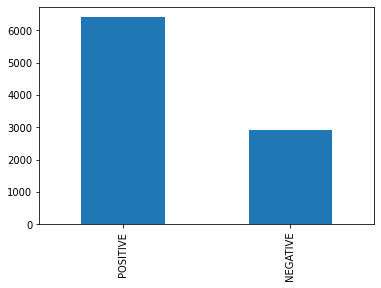

In [48]:
image_captions['hf_sent_class'].value_counts().plot(kind = 'bar')

In [49]:
image_captions['hf_sent_conf'].describe() 

count    9303.000000
mean        0.949668
std         0.098914
min         0.500172
25%         0.960117
50%         0.992913
75%         0.998537
max         0.999889
Name: hf_sent_conf, dtype: float64

Looks a bit more balanced using huggingface!

### Huggingface caption confidence thresholds

<AxesSubplot:ylabel='Frequency'>

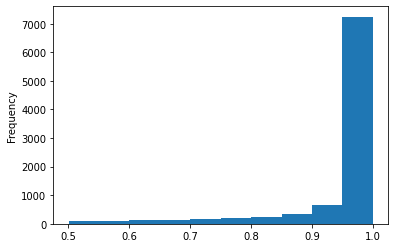

In [50]:
image_captions['hf_sent_conf'].plot.hist()

In [51]:
q = np.linspace(.1, 1, 9, 0)
image_captions['hf_sent_conf'].quantile(q)

0.1    0.828378
0.2    0.938458
0.3    0.972262
0.4    0.986283
0.5    0.992913
0.6    0.996107
0.7    0.997896
0.8    0.998998
0.9    0.999596
Name: hf_sent_conf, dtype: float64

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

<AxesSubplot:>

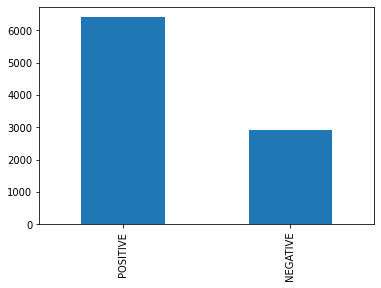

In [52]:
image_captions['hf_sent_class'].value_counts().plot(kind = 'bar')

In [53]:
image_captions['hf_sent_conf'].describe() 

count    9303.000000
mean        0.949668
std         0.098914
min         0.500172
25%         0.960117
50%         0.992913
75%         0.998537
max         0.999889
Name: hf_sent_conf, dtype: float64

Looks a bit more balanced using huggingface!

### Huggingface caption confidence thresholds

<AxesSubplot:ylabel='Frequency'>

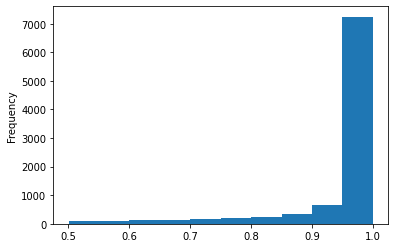

In [54]:
image_captions['hf_sent_conf'].plot.hist()

In [55]:
q = np.linspace(.1, 1, 9, 0)
image_captions['hf_sent_conf'].quantile(q)

0.1    0.828378
0.2    0.938458
0.3    0.972262
0.4    0.986283
0.5    0.992913
0.6    0.996107
0.7    0.997896
0.8    0.998998
0.9    0.999596
Name: hf_sent_conf, dtype: float64

As we can see, only 10% of the data has confidence under 80% - We are dealing with high confidence labels here!

Lets look at some images with high confidence positive/negative captions

In [92]:
def display_samples_with_hf_label(meta_df, label, conf_thresh=0.9,num_samples=5, seed = 0):
    
    #setting colors
    if(label=="POSITIVE"):
        color = 'green'
    else:
        color = 'red'
    #filter to see high confidence examples of desired labels
    high_conf = meta_df[meta_df['hf_sent_class'] == label]
    high_conf = high_conf[high_conf['hf_sent_conf'] >= conf_thresh]
    #sample num_sample rows from the dataframe
    samples = high_conf.sample(n=num_samples,random_state = 0)
    for idx,row in samples.iterrows():
        file_name = row['image_path']
        caption = row['caption']
        #get objects and confidence scores
        objects = row['objects'].split(',')
        confidences = row['object_confidence'].split(',')
        sent_label_conf_str = (row['hf_sent_class'],str(row['hf_sent_conf']))
        
        obj_conf = [str((obj,conf[0:4])) for obj,conf in zip(objects,confidences)]
        num_obj = len(obj_conf)
        obj_str = "\n".join(obj_conf)
        image = Image.open(file_name)
        fig = plt.figure(figsize=(10,(0.3*num_obj)))
        ax = fig.add_subplot(121)
        
                         
        plt.xticks([])
        plt.yticks([])
        ax.imshow(image) 
        ax.set_title(caption)
        ax = fig.add_subplot(122)
        ax.text(0.1, 1, sent_label_conf_str, horizontalalignment='left',verticalalignment='top', fontsize = 11, color = color, bbox=dict(boxstyle = "square", color='white' ))
        
        ax.text(0.1, 0.5, obj_str, horizontalalignment='left',verticalalignment='center')
        plt.xticks([])
        plt.yticks([])
        plt.show()
        

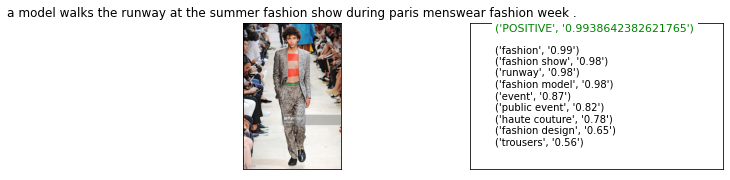

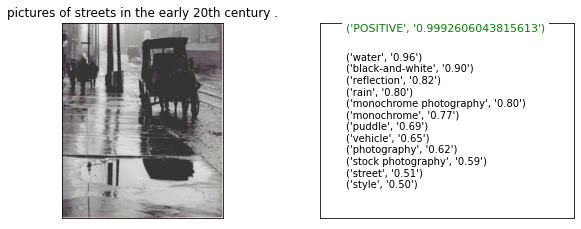

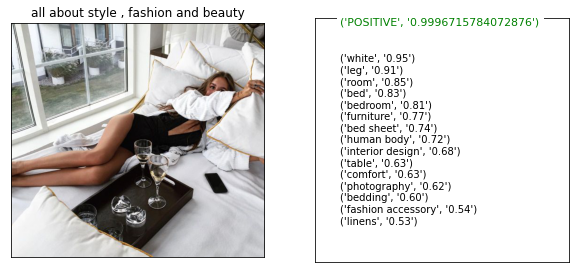

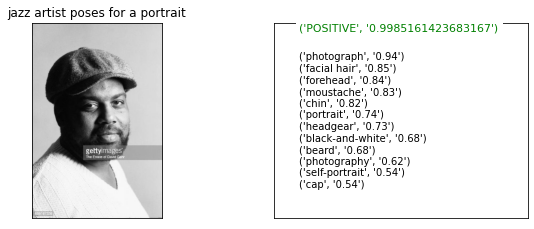

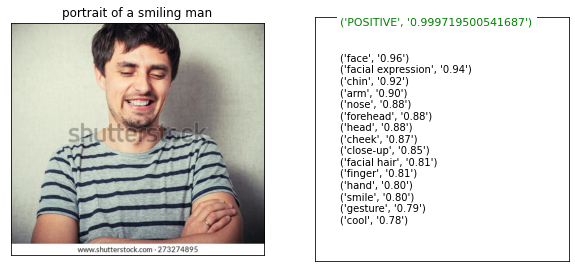

In [93]:
display_samples_with_hf_label(image_captions, "POSITIVE")

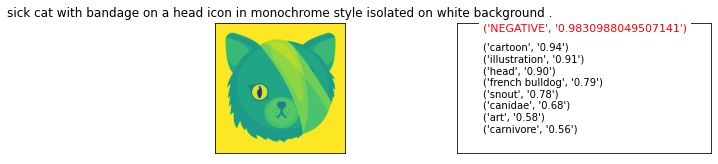

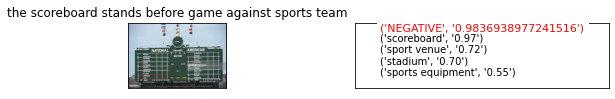

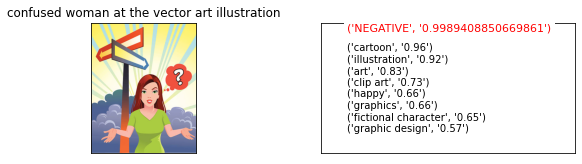

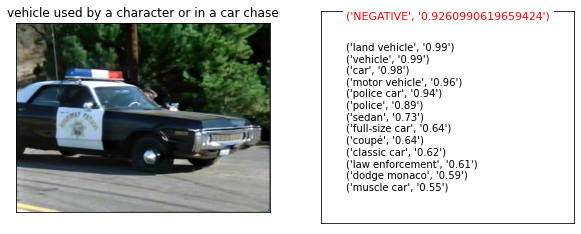

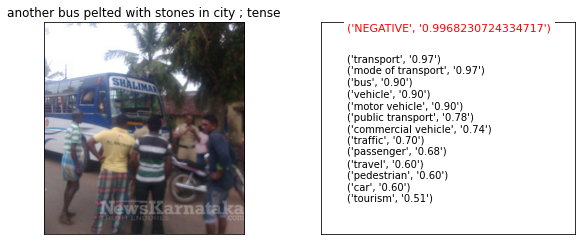

In [94]:
display_samples_with_hf_label(image_captions, "NEGATIVE")